## Importing dependencies

In [1]:
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, EfficientNetB0, InceptionResNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
import glob
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_score,recall_score,f1_score,classification_report
from sklearn.preprocessing import label_binarize

# Read And Combining train dataset 

In [122]:
# number of class
n_class = 5

# path to dataset
root_path = "KneeXrayData/ClsKLData/"

# list of folders
folder_list = ['kneeKL224','kneeKL299']#os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        for fold in ["train","test",'val']:
            
            # get all the images path inside the current folder
            image_list = [ file for file in glob.glob(f"{root_path}{folder}/{fold}/{label}/**.png", recursive=True)]#os.listdir(f"{root_path}{folder}/{label}/")
            # add to the image path list
            image_path_list += [ path for path in image_list]#f"{root_path}{folder}/{label}/"+ 

            # add labels to the label list
            label_list += [label] * len(image_list)

# convert to dataframe
df_data_all = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [9]:
image = []
for file in glob.glob("KneeXrayData/ClsKLData/kneeKL224/test/1/**.png", recursive=True):
    image.append(file)

In [100]:
df_train.to_csv('df_train_new.csv')

In [123]:
df_data_all.shape

(19572, 2)

# Observation
### Lets look at class distribution

Text(0, 0.5, 'count')

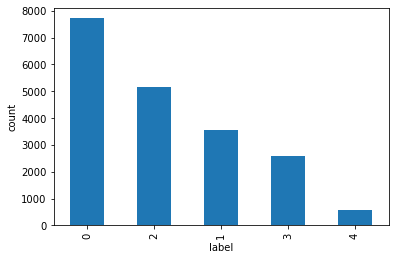

In [124]:
df_train = pd.read_csv('df_train.csv')
df_data_all.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [133]:
df_val_new['label'].value_counts()

0    1403
2     937
1     628
3     500
4     116
Name: label, dtype: int64

In [101]:
pd.read_csv('df_train_new.csv').shape

(17920, 3)

## DataGenerator train and validation
We will use kaggle dataset as train set and compitition dataset as validation set. If train and validation metric is similar, it shows their distribution is similar and hence we can use kaggle dataset as well.

In [3]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

# Augmentation 1

In [4]:
# train data generator object
train_aug1 = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True, rotation_range = 20,horizontal_flip = True, rescale=1./255)

# validation data generator object
valid_aug1 = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True, rotation_range = 20,horizontal_flip = True, rescale=1./255)

# Split the training, val, and testing data

In [5]:
training_set = pd.read_csv('df_train_new.csv')
X_train = training_set['filepath']
y_train = training_set['label']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.2)

In [7]:
df_train_new = pd.DataFrame({"filepath" : X_train, "label": y_train})
df_val_new = pd.DataFrame({"filepath" : X_val, "label": y_val})

In [8]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_new.label.values),
                                                 y= df_train_new.label.values)
class_weights = dict(enumerate(class_weights))

# Create trianing and val generator

In [9]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_new,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 14336 validated image filenames.


In [10]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_new,
x_col= "filepath",
y_col= "label",
batch_size= 8,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 3584 validated image filenames.


# Model 2: VGG16

In [117]:
# create train generator
train_generator_EN = train_aug1.flow_from_dataframe(
dataframe=df_train_new,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 14336 validated image filenames.


In [118]:
# create validation generator
valid_generator_EN = valid_aug1.flow_from_dataframe( 
dataframe= df_val_new,
x_col= "filepath",
y_col= "label",
batch_size= 8,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 3584 validated image filenames.


## arch1

In [33]:
#number of classes
n_class = 5
#download pre trained model
efficientNetB7 = VGG16(
    input_shape=(224,224,3),
    weights='imagenet')
#use the last fifth layer output as output
x=  efficientNetB7.layers[-5].output
#build the architecture
x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

efficientNet_model = Model(inputs=efficientNetB7.input,outputs=pred)

## arch2

In [115]:
n_class = 5
efficientNetB7 = VGG16(
    
    input_shape=(224,224,3),
    weights='imagenet')
x=  efficientNetB7.layers[-5].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

efficientNet_model = Model(inputs=efficientNetB7.input,outputs=pred)

In [116]:
# compile
efficientNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "VGG_arch2_aug1_baseline_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=10,
                                verbose=1)
]

## arch1 && aug

Epoch 1/100
448/448 [==============================] - 148s 330ms/step - loss: 1.1322 - acc: 0.5077 - val_loss: 1.2528 - val_acc: 0.5229

Epoch 00001: val_acc improved from -inf to 0.52288, saving model to VGG_arch1_aug_baseline_best.ckpt
Epoch 2/100
448/448 [==============================] - 64s 143ms/step - loss: 0.9706 - acc: 0.6037 - val_loss: 1.2017 - val_acc: 0.5391

Epoch 00002: val_acc improved from 0.52288 to 0.53906, saving model to VGG_arch1_aug_baseline_best.ckpt
Epoch 3/100
448/448 [==============================] - 69s 154ms/step - loss: 0.8886 - acc: 0.6524 - val_loss: 1.1355 - val_acc: 0.6334

Epoch 00003: val_acc improved from 0.53906 to 0.63337, saving model to VGG_arch1_aug_baseline_best.ckpt
Epoch 4/100
448/448 [==============================] - 71s 159ms/step - loss: 0.8096 - acc: 0.6995 - val_loss: 1.2290 - val_acc: 0.5725

Epoch 00004: val_acc did not improve from 0.63337
Epoch 5/100
448/448 [==============================] - 67s 150ms/step - loss: 0.7349 - acc: 

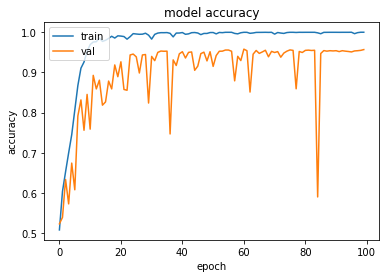

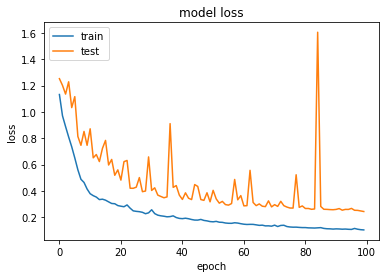

In [21]:
from matplotlib import pyplot as plt
# train the model
history = efficientNet_model.fit(
        train_generator_EN,
        epochs=100,
        validation_data=valid_generator_EN,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
efficientNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
efficientNet_model.load_weights('VGG_arch1_aug_baseline_best.ckpt')
# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = efficientNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 7s 4ms/step


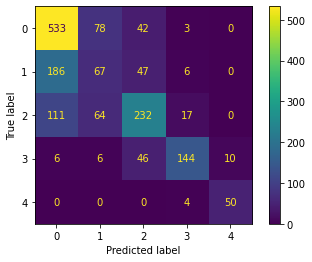

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

### calculate the performance metrics

In [70]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.8125     0.21895425 0.54716981 0.67924528 0.92592593]
Precision_score:  0.6210653753026635
Recall_score:  0.6210653753026635
F1_score:  0.6210653753026635
Classification_report:                precision    recall  f1-score   support

           0       0.64      0.81      0.71       656
           1       0.31      0.22      0.26       306
           2       0.63      0.55      0.59       424
           3       0.83      0.68      0.75       212
           4       0.83      0.93      0.88        54

    accuracy                           0.62      1652
   macro avg       0.65      0.64      0.64      1652
weighted avg       0.61      0.62      0.61      1652

{0: 0.2105724728181017, 1: 0.391370218221018, 2: 0.6316510202200233, 3: 0.9022012578616352, 4: 0.9926992073425115}


## arch2 && aug

Epoch 1/100
448/448 [==============================] - 64s 140ms/step - loss: 1.3126 - acc: 0.3929 - val_loss: 1.6626 - val_acc: 0.4771

Epoch 00001: val_acc improved from -inf to 0.47712, saving model to VGG_arch2_aug_baseline_best.ckpt
Epoch 2/100
448/448 [==============================] - 63s 141ms/step - loss: 1.0019 - acc: 0.5996 - val_loss: 1.1932 - val_acc: 0.5458

Epoch 00002: val_acc improved from 0.47712 to 0.54576, saving model to VGG_arch2_aug_baseline_best.ckpt
Epoch 3/100
448/448 [==============================] - 63s 140ms/step - loss: 0.9093 - acc: 0.6541 - val_loss: 1.1550 - val_acc: 0.5268

Epoch 00003: val_acc did not improve from 0.54576
Epoch 4/100
448/448 [==============================] - 63s 141ms/step - loss: 0.8386 - acc: 0.6938 - val_loss: 1.2331 - val_acc: 0.5491

Epoch 00004: val_acc improved from 0.54576 to 0.54911, saving model to VGG_arch2_aug_baseline_best.ckpt
Epoch 5/100
448/448 [==============================] - 63s 140ms/step - loss: 0.7702 - acc: 0

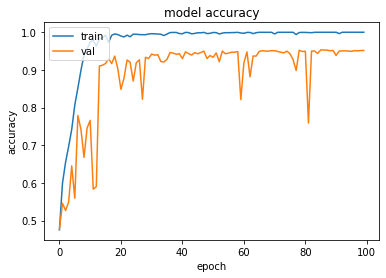

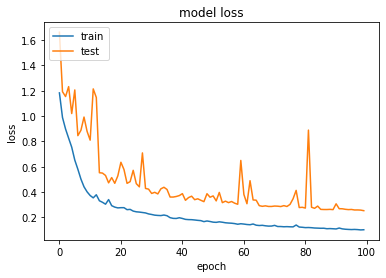

In [386]:
from matplotlib import pyplot as plt
#efficientNet_model.trainable = False
# train the model
history = efficientNet_model.fit(
        train_generator_EN,
        epochs=100,
        validation_data=valid_generator_EN,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
efficientNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
efficientNet_model.load_weights('VGG_arch2_aug_baseline_best.ckpt')
# test generator
compi_gen = valid_aug1.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = efficientNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
   1/1652 [..............................] - ETA: 4:08

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1652/1652 [==============================] - 20s 12ms/step


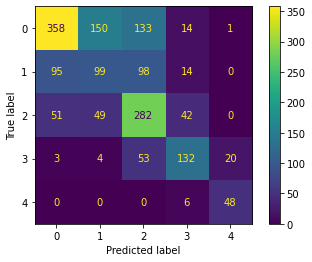

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [75]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.54573171 0.32352941 0.66509434 0.62264151 0.88888889]
Precision_score:  0.5562953995157385
Recall_score:  0.5562953995157385
F1_score:  0.5562953995157385
Classification_report:                precision    recall  f1-score   support

           0       0.71      0.55      0.62       656
           1       0.33      0.32      0.33       306
           2       0.50      0.67      0.57       424
           3       0.63      0.62      0.63       212
           4       0.70      0.89      0.78        54

    accuracy                           0.56      1652
   macro avg       0.57      0.61      0.58      1652
weighted avg       0.57      0.56      0.56      1652

{0: 0.21709475095503966, 1: 0.41305757072516974, 2: 0.6248549950832771, 3: 0.8725579795597483, 4: 0.9856765401195939}


## arch1 && aug1

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
448/448 [==============================] - 153s 340ms/step - loss: 1.4223 - acc: 0.3081 - val_loss: 1.4109 - val_acc: 0.4595

Epoch 00001: val_acc improved from -inf to 0.45954, saving model to VGG_arch1_aug_baseline_best.ckpt
Epoch 2/100
448/448 [==============================] - 153s 342ms/step - loss: 1.0829 - acc: 0.5438 - val_loss: 1.2151 - val_acc: 0.5368

Epoch 00002: val_acc improved from 0.45954 to 0.53683, saving model to VGG_arch1_aug_baseline_best.ckpt
Epoch 3/100
448/448 [==============================] - 152s 339ms/step - loss: 1.0132 - acc: 0.5900 - val_loss: 1.1566 - val_acc: 0.5667

Epoch 00003: val_acc improved from 0.53683 to 0.56669, saving model to VGG_arch1_aug_baseline_best.ckpt
Epoch 4/100
448/448 [==============================] - 154s 343ms/step - loss: 0.9489 - acc: 0.6197 - val_loss: 1.2919 - val_acc: 0.5299

Epoch 00004: val_acc did not improve from 0.56669
Epoch 5/100
448/448 [==============================] - 153s 342ms/step - loss: 0.9119 - a

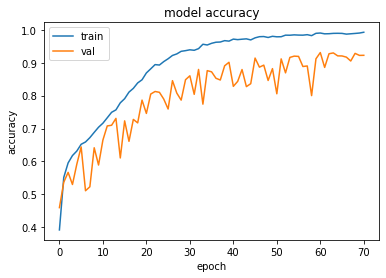

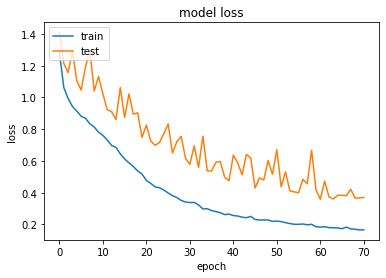

In [35]:
from matplotlib import pyplot as plt
# train the model
history = efficientNet_model.fit(
        train_generator_EN,
        epochs=100,
        validation_data=valid_generator_EN,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
efficientNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
# test generator
compi_gen = valid_aug1.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = efficientNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 21s 13ms/step


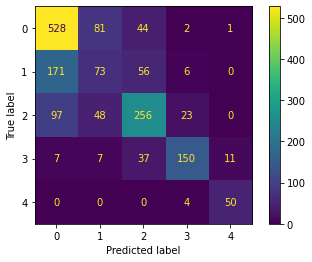

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [67]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.80487805 0.23856209 0.60377358 0.70754717 0.92592593]
Precision_score:  0.6398305084745762
Recall_score:  0.6398305084745762
F1_score:  0.6398305084745762
Classification_report:                precision    recall  f1-score   support

           0       0.66      0.80      0.72       656
           1       0.35      0.24      0.28       306
           2       0.65      0.60      0.63       424
           3       0.81      0.71      0.76       212
           4       0.81      0.93      0.86        54

    accuracy                           0.64      1652
   macro avg       0.66      0.66      0.65      1652
weighted avg       0.62      0.64      0.63      1652

{0: 0.19609153075717503, 1: 0.3999917450883276, 2: 0.6461572736770943, 3: 0.8970830057651991, 4: 0.9917721225606082}


## arch2 && aug1

In [28]:
from matplotlib import pyplot as plt
# train the model
history = efficientNet_model.fit(
        train_generator_EN,
        epochs=100,
        validation_data=valid_generator_EN,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
efficientNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
 24/448 [>.............................] - ETA: 1:54 - loss: 0.9157 - acc: 0.6745

KeyboardInterrupt: 

In [119]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
efficientNet_model.load_weights('VGG_arch2_aug1_best.ckpt')
X_test = pd.read_csv("df_val.csv")
# test generator
compi_gen = valid_aug1.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = efficientNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
   1/1652 [..............................] - ETA: 3:59

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1652/1652 [==============================] - 21s 13ms/step


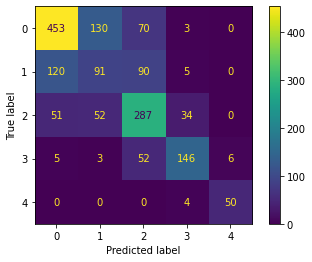

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [121]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')#,pos_label =[0,1,2,3,4]
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')#,pos_label =[0,1,2,3,4]
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])#, average = 'micro')
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.69054878 0.29738562 0.67688679 0.68867925 0.92592593]
Precision_score:  0.6216707021791767
Recall_score:  0.6216707021791767
F1_score:  0.6216707021791767
Classification_report:                precision    recall  f1-score   support

           0       0.72      0.69      0.71       656
           1       0.33      0.30      0.31       306
           2       0.58      0.68      0.62       424
           3       0.76      0.69      0.72       212
           4       0.89      0.93      0.91        54

    accuracy                           0.62      1652
   macro avg       0.66      0.66      0.65      1652
weighted avg       0.62      0.62      0.62      1652

{0: 0.1719155585757665, 1: 0.4179024755023357, 2: 0.6690910976584107, 3: 0.8850219470649895, 4: 0.9936262921244148}


In [212]:
n_class = 5
#xception = Xception(weights="imagenet",)
efficientNet = EfficientNetB0(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet')
x=  efficientNet.output#.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

#x = tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, padding= "same")(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

efficientNet_model = Model(inputs=efficientNet.input,outputs=pred)

In [214]:
# compile
efficientNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "efficientNet_arch1_aug_baseline_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=10,
                                verbose=1)
]

# Model 3: InceptionRestNet

# Baseline

In [262]:
InceptionResNet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1234 (Conv2D)            (None, 111, 111, 32) 864         input_51[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1217 (Batch (None, 111, 111, 32) 96          conv2d_1234[0][0]                
__________________________________________________________________________________________________
activation_1149 (Activation)    (None, 111, 111, 32) 0           batch_normalization_1217[0][0]   
________________________________________________________________________________

In [12]:
n_class = 5
#xception = Xception(weights="imagenet",)
InceptionResNet = InceptionResNetV2(
    input_shape=(299,299,3),
    weights='imagenet')
x=  InceptionResNet.layers[-4].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

InceptionResNet_model = Model(inputs=InceptionResNet.input,outputs=pred)

## arch2

In [87]:
n_class = 5
#xception = Xception(weights="imagenet",)
InceptionResNet = InceptionResNetV2(
    #include_top=False,
    input_shape=(299,299,3),
    weights='imagenet')
x=  InceptionResNet.layers[-4].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

InceptionResNet_model = Model(inputs=InceptionResNet.input,outputs=pred)

In [15]:
# compile
InceptionResNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "InceptionResNet_model_arch1_aug_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=10,
                                verbose=1)
]

## arch1 && baseline

Epoch 1/100
448/448 [==============================] - 279s 598ms/step - loss: 1.3075 - acc: 0.3905 - val_loss: 1.2189 - val_acc: 0.5304

Epoch 00001: val_acc improved from -inf to 0.53041, saving model to InceptionResNet_model_arch1_aug_best.ckpt
Epoch 2/100
448/448 [==============================] - 115s 256ms/step - loss: 0.8592 - acc: 0.6815 - val_loss: 1.0479 - val_acc: 0.6747

Epoch 00002: val_acc improved from 0.53041 to 0.67467, saving model to InceptionResNet_model_arch1_aug_best.ckpt
Epoch 3/100
448/448 [==============================] - 115s 256ms/step - loss: 0.6436 - acc: 0.8200 - val_loss: 0.9171 - val_acc: 0.7391

Epoch 00003: val_acc improved from 0.67467 to 0.73912, saving model to InceptionResNet_model_arch1_aug_best.ckpt
Epoch 4/100
448/448 [==============================] - 115s 256ms/step - loss: 0.5474 - acc: 0.8926 - val_loss: 0.8792 - val_acc: 0.7704

Epoch 00004: val_acc improved from 0.73912 to 0.77037, saving model to InceptionResNet_model_arch1_aug_best.ckpt

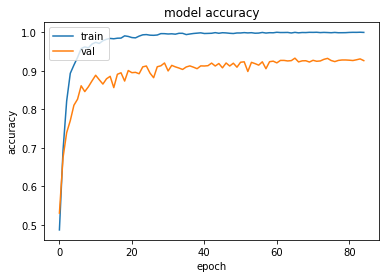

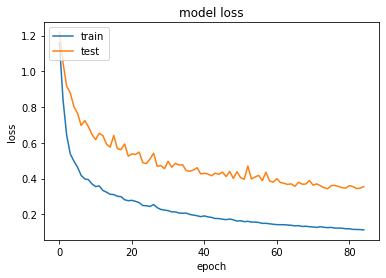

In [16]:
from matplotlib import pyplot as plt
#InceptionResNet_model.trainable = False
# train the model
history = InceptionResNet_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
InceptionResNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# prediction on train data
target_shape = 299
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
# test generator
#InceptionResNet_model.load_weights('InceptionResNet_model_arch1_aug_baseline_best.ckpt')
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = InceptionResNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 204s 31ms/step


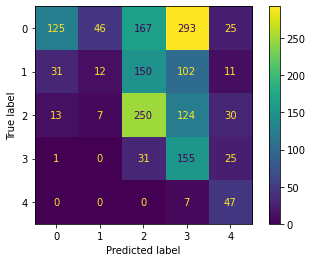

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [19]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.19054878 0.03921569 0.58962264 0.73113208 0.87037037]
Precision_score:  0.3565375302663438
Recall_score:  0.3565375302663438
F1_score:  0.35653753026634377
Classification_report:                precision    recall  f1-score   support

           0       0.74      0.19      0.30       656
           1       0.18      0.04      0.06       306
           2       0.42      0.59      0.49       424
           3       0.23      0.73      0.35       212
           4       0.34      0.87      0.49        54

    accuracy                           0.36      1652
   macro avg       0.38      0.48      0.34      1652
weighted avg       0.47      0.36      0.32      1652

{0: 0.4245036548633559, 1: 0.4259947168565297, 2: 0.45928818910945846, 3: 0.7063499082809224, 4: 0.9404985398414685}


## arch2 && aug baseline

Epoch 1/100
448/448 [==============================] - 128s 260ms/step - loss: 1.3716 - acc: 0.3620 - val_loss: 1.1889 - val_acc: 0.5857

Epoch 00001: val_acc improved from -inf to 0.58566, saving model to InceptionResNet_model_arch2_aug_baseline_best.ckpt
Epoch 2/100
448/448 [==============================] - 115s 257ms/step - loss: 0.9214 - acc: 0.6548 - val_loss: 1.1437 - val_acc: 0.6108

Epoch 00002: val_acc improved from 0.58566 to 0.61077, saving model to InceptionResNet_model_arch2_aug_baseline_best.ckpt
Epoch 3/100
448/448 [==============================] - 115s 256ms/step - loss: 0.7155 - acc: 0.7872 - val_loss: 1.0951 - val_acc: 0.6568

Epoch 00003: val_acc improved from 0.61077 to 0.65681, saving model to InceptionResNet_model_arch2_aug_baseline_best.ckpt
Epoch 4/100
448/448 [==============================] - 115s 256ms/step - loss: 0.5919 - acc: 0.8749 - val_loss: 0.8452 - val_acc: 0.7997

Epoch 00004: val_acc improved from 0.65681 to 0.79967, saving model to InceptionResNe

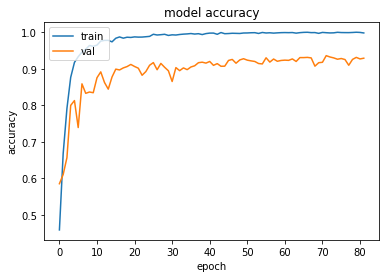

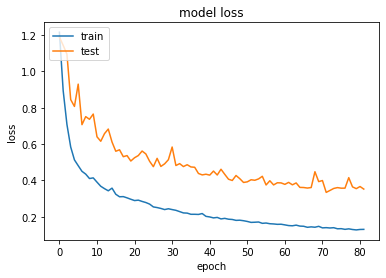

In [412]:
from matplotlib import pyplot as plt
#InceptionResNet_model.trainable = False
# train the model
history = InceptionResNet_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
InceptionResNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:
# prediction on train data
target_shape = 299
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
InceptionResNet_model.load_weights('InceptionResNet_model_arch2_aug_baseline_best.ckpt')
# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = InceptionResNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 46s 26ms/step


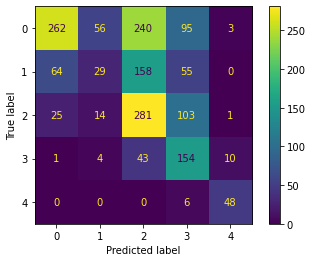

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [91]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.39939024 0.09477124 0.66273585 0.72641509 0.88888889]
Precision_score:  0.4685230024213075
Recall_score:  0.4685230024213075
F1_score:  0.4685230024213075
Classification_report:                precision    recall  f1-score   support

           0       0.74      0.40      0.52       656
           1       0.28      0.09      0.14       306
           2       0.39      0.66      0.49       424
           3       0.37      0.73      0.49       212
           4       0.77      0.89      0.83        54

    accuracy                           0.47      1652
   macro avg       0.51      0.55      0.49      1652
weighted avg       0.52      0.47      0.45      1652

{0: 0.2841786352727985, 1: 0.4398605405510396, 2: 0.5638453767439002, 3: 0.7982016509433961, 4: 0.9809831734112084}


## arch2 && aug1

Epoch 1/100
448/448 [==============================] - 402s 872ms/step - loss: 1.2702 - acc: 0.4123 - val_loss: 1.4146 - val_acc: 0.5206

Epoch 00001: val_acc improved from -inf to 0.52065, saving model to InceptionResNet_model_arch2_aug1_best.ckpt
Epoch 2/100
448/448 [==============================] - 160s 358ms/step - loss: 1.0095 - acc: 0.5781 - val_loss: 1.1006 - val_acc: 0.6328

Epoch 00002: val_acc improved from 0.52065 to 0.63281, saving model to InceptionResNet_model_arch2_aug1_best.ckpt
Epoch 3/100
448/448 [==============================] - 159s 354ms/step - loss: 0.9201 - acc: 0.6370 - val_loss: 1.1328 - val_acc: 0.6119

Epoch 00003: val_acc did not improve from 0.63281
Epoch 4/100
448/448 [==============================] - 158s 353ms/step - loss: 0.8519 - acc: 0.6814 - val_loss: 1.0061 - val_acc: 0.6816

Epoch 00004: val_acc improved from 0.63281 to 0.68164, saving model to InceptionResNet_model_arch2_aug1_best.ckpt
Epoch 5/100
448/448 [==============================] - 158s

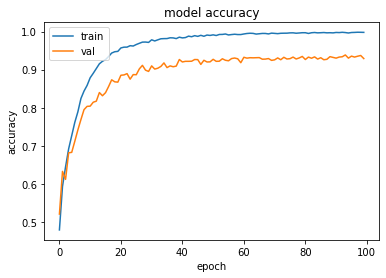

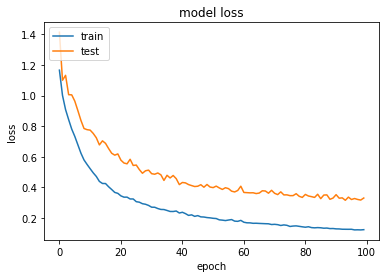

In [24]:
from matplotlib import pyplot as plt
#InceptionResNet_model.trainable = False
# train the model
history = InceptionResNet_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
InceptionResNet_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #RAISE ERROR
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
# prediction on train data
target_shape = 299
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
InceptionResNet_model.load_weights('InceptionResNet_model_arch2_aug1_best.ckpt')
# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = InceptionResNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 42s 25ms/step


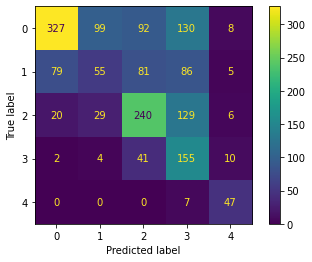

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [94]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.49847561 0.17973856 0.56603774 0.73113208 0.87037037]
Precision_score:  0.49878934624697335
Recall_score:  0.49878934624697335
F1_score:  0.49878934624697335
Classification_report:                precision    recall  f1-score   support

           0       0.76      0.50      0.60       656
           1       0.29      0.18      0.22       306
           2       0.53      0.57      0.55       424
           3       0.31      0.73      0.43       212
           4       0.62      0.87      0.72        54

    accuracy                           0.50      1652
   macro avg       0.50      0.57      0.51      1652
weighted avg       0.55      0.50      0.50      1652

{0: 0.25825787907728476, 1: 0.45833576124853115, 2: 0.5989989859258804, 3: 0.772050248951782, 4: 0.9694699392759468}


In [49]:
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.preprocessing import label_binarize
ytest = label_binarize(X_test.label,classes = [0, 1, 2, 3, 4])
ypred = label_binarize(class_prediction_compi,classes = [0, 1, 2, 3, 4])
roc_auc_score(ytest,ypred, average = 'macro', multi_class = "ovr")
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

{0: 0.25825787907728476, 1: 0.45833576124853115, 2: 0.5989989859258804, 3: 0.772050248951782, 4: 0.9694699392759468}


## arch1 && aug1

In [288]:
n_class = 5
#xception = Xception(weights="imagenet",)
InceptionResNet_arch1_aug1 = InceptionResNetV2(
    #include_top=False,
    input_shape=(299,299,3),
    weights='imagenet')
x=  InceptionResNet_arch1_aug1.layers[-4].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

InceptionResNet_arch1_aug1_model = Model(inputs=InceptionResNet_arch1_aug1.input,outputs=pred)

In [289]:
# compile
InceptionResNet_arch1_aug1_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "InceptionResNet_model_arch1_aug1__best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=10,
                                verbose=1)
]

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
448/448 [==============================] - 166s 345ms/step - loss: 1.3604 - acc: 0.3656 - val_loss: 1.1728 - val_acc: 0.5792

Epoch 00001: val_acc improved from -inf to 0.57924, saving model to InceptionResNet_model_arch1_aug1__best.ckpt
Epoch 2/100
448/448 [==============================] - 152s 339ms/step - loss: 0.9994 - acc: 0.5889 - val_loss: 1.1232 - val_acc: 0.6200

Epoch 00002: val_acc improved from 0.57924 to 0.61998, saving model to InceptionResNet_model_arch1_aug1__best.ckpt
Epoch 3/100
448/448 [==============================] - 152s 339ms/step - loss: 0.8984 - acc: 0.6435 - val_loss: 1.0183 - val_acc: 0.6551

Epoch 00003: val_acc improved from 0.61998 to 0.65513, saving model to InceptionResNet_model_arch1_aug1__best.ckpt
Epoch 4/100
448/448 [==============================] - 152s 340ms/step - loss: 0.8363 - acc: 0.6910 - val_loss: 1.1068 - val_acc: 0.6225

Epoch 00004: val_acc did not improve from 0.65513
Epoch 5/100
448/448 [==============================] - 1

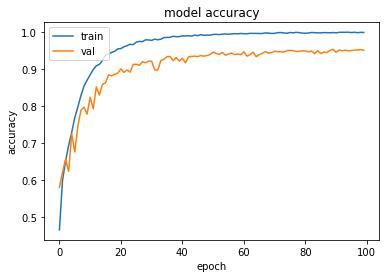

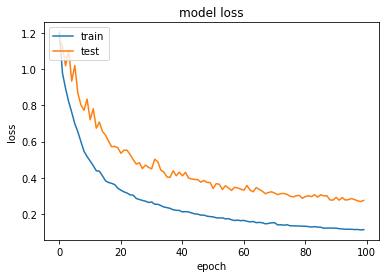

In [290]:
from matplotlib import pyplot as plt
# train the model
history = InceptionResNet_arch1_aug1_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
InceptionResNet_arch1_aug1_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [84]:
# prediction on train data
target_shape = 299
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
InceptionResNet_model.load_weights('InceptionResNet_model_arch1_aug1__best.ckpt')
# test generator
compi_gen = valid_aug1.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = InceptionResNet_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
   5/1652 [..............................] - ETA: 47s

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1652/1652 [==============================] - 42s 25ms/step


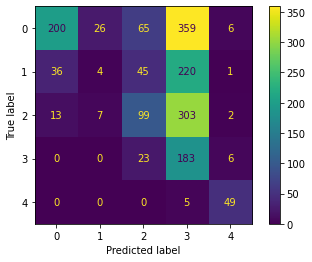

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [86]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.30487805 0.0130719  0.23349057 0.86320755 0.90740741]
Precision_score:  0.3238498789346247
Recall_score:  0.3238498789346247
F1_score:  0.3238498789346247
Classification_report:                precision    recall  f1-score   support

           0       0.80      0.30      0.44       656
           1       0.11      0.01      0.02       306
           2       0.43      0.23      0.30       424
           3       0.17      0.86      0.29       212
           4       0.77      0.91      0.83        54

    accuracy                           0.32      1652
   macro avg       0.45      0.46      0.38      1652
weighted avg       0.50      0.32      0.32      1652

{0: 0.35288103634048384, 1: 0.510114694713943, 2: 0.5295080204044005, 3: 0.6197359800838574, 4: 0.9640175219023779}


# Weighting Classes
As we have unevenly class distibution, we will weight them based on the number of samples

In [11]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

# Model Architecture : Xception
Here we will be using Xception by google. (I encourage you to try different architectures)

In [96]:
n_class = 5
xception = Xception(weights="imagenet",)
x=  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs=pred)


## arch2

In [106]:
n_class = 5
#xception = Xception(weights="imagenet",)
xception = Xception(weights="imagenet",)
x=  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs=pred)

In [107]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_arch2_aug1_second_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=10,
                                verbose=1)
]

# Model 1: Xception_arch1_aug_baseline

Epoch 1/100
448/448 [==============================] - 128s 278ms/step - loss: 1.3338 - acc: 0.3754 - val_loss: 1.3228 - val_acc: 0.4741

Epoch 00001: val_acc improved from -inf to 0.47405, saving model to xception_best.ckpt
Epoch 2/100
448/448 [==============================] - 124s 276ms/step - loss: 0.8873 - acc: 0.6515 - val_loss: 1.0283 - val_acc: 0.6842

Epoch 00002: val_acc improved from 0.47405 to 0.68415, saving model to xception_best.ckpt
Epoch 3/100
448/448 [==============================] - 124s 278ms/step - loss: 0.6225 - acc: 0.8381 - val_loss: 0.9611 - val_acc: 0.7296

Epoch 00003: val_acc improved from 0.68415 to 0.72963, saving model to xception_best.ckpt
Epoch 4/100
448/448 [==============================] - 125s 278ms/step - loss: 0.5130 - acc: 0.9150 - val_loss: 0.9446 - val_acc: 0.7609

Epoch 00004: val_acc improved from 0.72963 to 0.76088, saving model to xception_best.ckpt
Epoch 5/100
448/448 [==============================] - 125s 279ms/step - loss: 0.4570 - acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



448/448 [==============================] - 125s 278ms/step - loss: 0.1260 - acc: 0.9990 - val_loss: 0.3603 - val_acc: 0.9258

Epoch 00074: val_acc did not improve from 0.92718
Epoch 75/100
448/448 [==============================] - 125s 279ms/step - loss: 0.1281 - acc: 0.9991 - val_loss: 0.3636 - val_acc: 0.9238

Epoch 00075: val_acc did not improve from 0.92718
Epoch 76/100
448/448 [==============================] - 125s 279ms/step - loss: 0.1253 - acc: 0.9996 - val_loss: 0.3698 - val_acc: 0.9202

Epoch 00076: val_acc did not improve from 0.92718
Epoch 77/100
448/448 [==============================] - 125s 279ms/step - loss: 0.1226 - acc: 0.9996 - val_loss: 0.3533 - val_acc: 0.9249

Epoch 00077: val_acc did not improve from 0.92718
Epoch 78/100
448/448 [==============================] - 125s 278ms/step - loss: 0.1199 - acc: 1.0000 - val_loss: 0.3486 - val_acc: 0.9272

Epoch 00078: val_acc did not improve from 0.92718
Epoch 79/100
448/448 [==============================] - 124s 278ms/s

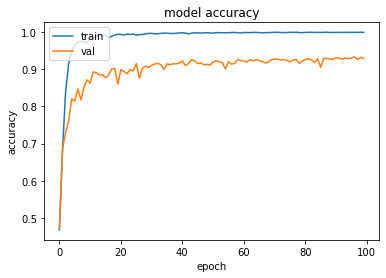

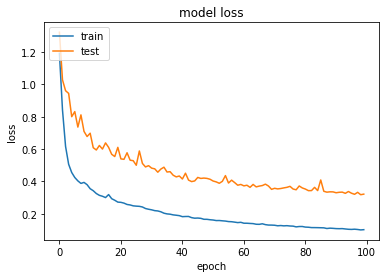

In [155]:
from matplotlib import pyplot as plt
# train the model
history = xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
xception_model.load_weights('xception_best.ckpt')
# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 85s 8ms/step


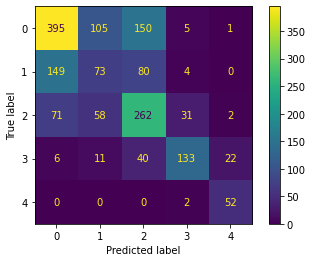

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [100]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.60213415 0.23856209 0.61792453 0.62735849 0.96296296]
Precision_score:  0.5538740920096852
Recall_score:  0.5538740920096852
F1_score:  0.5538740920096852
Classification_report:                precision    recall  f1-score   support

           0       0.64      0.60      0.62       656
           1       0.30      0.24      0.26       306
           2       0.49      0.62      0.55       424
           3       0.76      0.63      0.69       212
           4       0.68      0.96      0.79        54

    accuracy                           0.55      1652
   macro avg       0.57      0.61      0.58      1652
weighted avg       0.55      0.55      0.55      1652

{0: 0.25223301743559606, 1: 0.3653162602336625, 2: 0.6180205580480609, 3: 0.8722320492662474, 4: 0.9898831873174803}


## arch2 && aug baseline

Epoch 1/100
448/448 [==============================] - 130s 283ms/step - loss: 1.3073 - acc: 0.3924 - val_loss: 1.6867 - val_acc: 0.3426

Epoch 00001: val_acc improved from -inf to 0.34263, saving model to xception_arch2_aug_baseline_best.ckpt
Epoch 2/100
448/448 [==============================] - 126s 280ms/step - loss: 0.8727 - acc: 0.6707 - val_loss: 0.9943 - val_acc: 0.6917

Epoch 00002: val_acc improved from 0.34263 to 0.69169, saving model to xception_arch2_aug_baseline_best.ckpt
Epoch 3/100
448/448 [==============================] - 126s 281ms/step - loss: 0.6500 - acc: 0.8271 - val_loss: 0.9829 - val_acc: 0.7093

Epoch 00003: val_acc improved from 0.69169 to 0.70926, saving model to xception_arch2_aug_baseline_best.ckpt
Epoch 4/100
448/448 [==============================] - 126s 281ms/step - loss: 0.5319 - acc: 0.9076 - val_loss: 0.7930 - val_acc: 0.8273

Epoch 00004: val_acc improved from 0.70926 to 0.82729, saving model to xception_arch2_aug_baseline_best.ckpt
Epoch 5/100
448

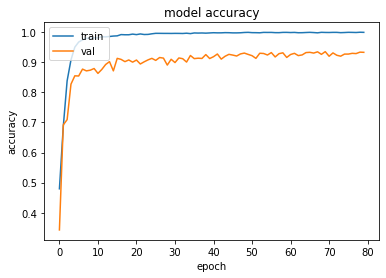

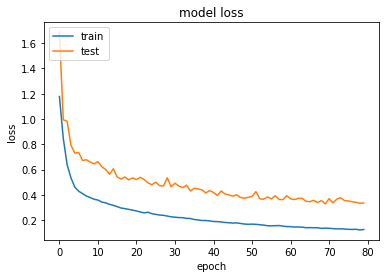

In [417]:
from matplotlib import pyplot as plt
# train the model
history = xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
xception_model.load_weights('xception_arch2_aug_baseline_best.ckpt')
# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
1652/1652 [==============================] - 14s 8ms/step


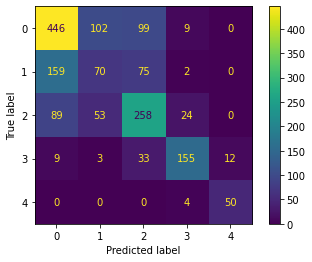

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [110]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.67987805 0.22875817 0.60849057 0.73113208 0.92592593]
Precision_score:  0.5926150121065376
Recall_score:  0.5926150121065376
F1_score:  0.5926150121065376
Classification_report:                precision    recall  f1-score   support

           0       0.63      0.68      0.66       656
           1       0.31      0.23      0.26       306
           2       0.55      0.61      0.58       424
           3       0.80      0.73      0.76       212
           4       0.81      0.93      0.86        54

    accuracy                           0.59      1652
   macro avg       0.62      0.63      0.62      1652
weighted avg       0.58      0.59      0.58      1652

{0: 0.23502317195611716, 1: 0.3799905796890326, 2: 0.6159568788027779, 3: 0.8923119758909853, 4: 0.9915635284846799}


# Model 1: Xception_arch1_aug1

Epoch 1/100
448/448 [==============================] - 161s 353ms/step - loss: 1.3590 - acc: 0.3791 - val_loss: 1.4263 - val_acc: 0.4718

Epoch 00001: val_acc improved from -inf to 0.47182, saving model to xception_best.ckpt
Epoch 2/100
448/448 [==============================] - 157s 350ms/step - loss: 1.0118 - acc: 0.5750 - val_loss: 1.2079 - val_acc: 0.5703

Epoch 00002: val_acc improved from 0.47182 to 0.57031, saving model to xception_best.ckpt
Epoch 3/100
448/448 [==============================] - 155s 346ms/step - loss: 0.9356 - acc: 0.6169 - val_loss: 1.1370 - val_acc: 0.5770

Epoch 00003: val_acc improved from 0.57031 to 0.57701, saving model to xception_best.ckpt
Epoch 4/100
448/448 [==============================] - 172s 383ms/step - loss: 0.8697 - acc: 0.6545 - val_loss: 1.0584 - val_acc: 0.6613

Epoch 00004: val_acc improved from 0.57701 to 0.66127, saving model to xception_best.ckpt
Epoch 5/100
448/448 [==============================] - 172s 383ms/step - loss: 0.8227 - acc

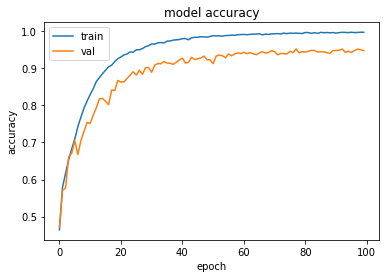

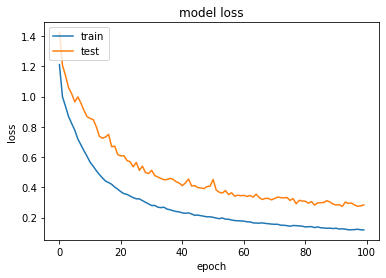

In [128]:
from matplotlib import pyplot as plt
# train the model
history = xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
xception_model.load_weights('xception_arch1_aug1_best.ckpt')
# test generator
compi_gen = valid_aug1.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
  12/1652 [..............................] - ETA: 17s

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1652/1652 [==============================] - 20s 12ms/step


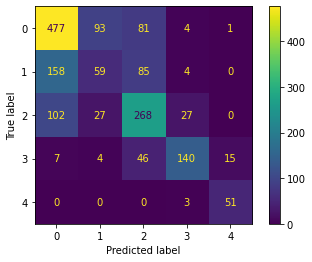

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [105]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.72713415 0.19281046 0.63207547 0.66037736 0.94444444]
Precision_score:  0.6023002421307506
Recall_score:  0.6023002421307506
F1_score:  0.6023002421307506
Classification_report:                precision    recall  f1-score   support

           0       0.64      0.73      0.68       656
           1       0.32      0.19      0.24       306
           2       0.56      0.63      0.59       424
           3       0.79      0.66      0.72       212
           4       0.76      0.94      0.84        54

    accuracy                           0.60      1652
   macro avg       0.61      0.63      0.62      1652
weighted avg       0.58      0.60      0.59      1652

{0: 0.21749651043197182, 1: 0.40408156823898456, 2: 0.6218166139143262, 3: 0.8872952699161426, 4: 0.991673619802531}


## arch2 && aug1

In [ ]:
from matplotlib import pyplot as plt
# train the model
history = xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
448/448 [==============================] - 164s 360ms/step - loss: 1.3694 - acc: 0.3344 - val_loss: 1.3862 - val_acc: 0.4785

Epoch 00001: val_acc improved from -inf to 0.47852, saving model to xception_arch2_aug1_second_best.ckpt
Epoch 2/100
448/448 [==============================] - 162s 361ms/step - loss: 1.0383 - acc: 0.5566 - val_loss: 1.1600 - val_acc: 0.6350

Epoch 00002: val_acc improved from 0.47852 to 0.63504, saving model to xception_arch2_aug1_second_best.ckpt
Epoch 3/100
448/448 [==============================] - 162s 361ms/step - loss: 0.9609 - acc: 0.6105 - val_loss: 1.0639 - val_acc: 0.6423

Epoch 00003: val_acc improved from 0.63504 to 0.64230, saving model to xception_arch2_aug1_second_best.ckpt
Epoch 4/100
448/448 [==============================] - 162s 362ms/step - loss: 0.8750 - acc: 0.6490 - val_loss: 1.0082 - val_acc: 0.6847

Epoch 00004: val_acc improved from 0.64230 to 0.68471, saving model to xception_arch2_aug1_second_best.ckpt
448/448 [==========

Epoch 1/20
448/448 [==============================] - 331s 738ms/step - loss: 0.1653 - acc: 0.9845 - val_loss: 0.1549 - val_acc: 0.9874

Epoch 00001: val_acc improved from -inf to 0.98744, saving model to xception_arch2_aug1_baseline_best.ckpt
Epoch 2/20
448/448 [==============================] - 160s 356ms/step - loss: 0.1557 - acc: 0.9866 - val_loss: 0.1681 - val_acc: 0.9883

Epoch 00002: val_acc improved from 0.98744 to 0.98828, saving model to xception_arch2_aug1_baseline_best.ckpt
Epoch 3/20
448/448 [==============================] - 161s 358ms/step - loss: 0.1505 - acc: 0.9887 - val_loss: 0.1624 - val_acc: 0.9869

Epoch 00003: val_acc did not improve from 0.98828
Epoch 4/20
448/448 [==============================] - 161s 358ms/step - loss: 0.1496 - acc: 0.9892 - val_loss: 0.1533 - val_acc: 0.9911

Epoch 00004: val_acc improved from 0.98828 to 0.99107, saving model to xception_arch2_aug1_baseline_best.ckpt
Epoch 5/20
448/448 [==============================] - 161s 359ms/step - los

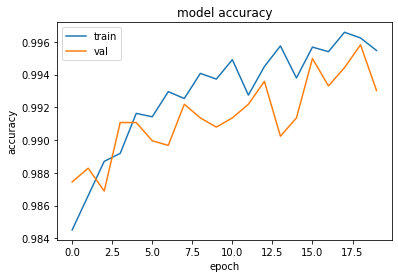

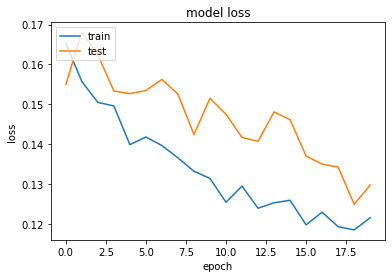

In [16]:
from matplotlib import pyplot as plt
# load best saved weights
xception_model.load_weights(checkpoint_path)
# train the model
history = xception_model.fit(
        train_generator,
        epochs=20,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [112]:
# prediction on train data
target_shape = 224
BATCH_SIZE = 1
X_test = pd.read_csv("df_val.csv")
xception_model.load_weights('xception_arch2_aug1_second_best.ckpt')
# test generator
compi_gen = valid_aug1.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

Found 1652 validated image filenames.
  11/1652 [..............................] - ETA: 19s

/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1652/1652 [==============================] - 20s 12ms/step


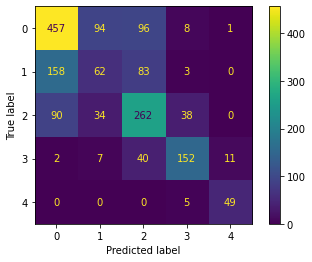

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [114]:
fp = cm.sum(axis =0)-np.diag(cm)
fn = cm.sum(axis =1)-np.diag(cm)
tp = np.diag(cm)
tn = cm.sum()-(fp+fn+tp)
specificity=tp/(tp+fn)
print('specificity: ',specificity)
Precision_score = precision_score(X_test.label, class_prediction_compi, average = 'micro')
Recall_score = recall_score(X_test.label, class_prediction_compi, average = 'micro')
F1_score = f1_score(X_test.label, class_prediction_compi,labels =[0,1,2,3,4], average = 'micro')
Classification_report = classification_report(X_test.label, class_prediction_compi,target_names =['0','1','2','3','4'])
print('Precision_score: ',Precision_score)
print('Recall_score: ',Recall_score)
print('F1_score: ',F1_score)
print('Classification_report: ',Classification_report)
dic = {}
for i in range(5):
    fpr,tpr,thresholds = roc_curve(X_test.label, class_prediction_compi,pos_label =i)
    dic[i] = auc(fpr,tpr)
print(dic)

specificity:  [0.69664634 0.20261438 0.61792453 0.71698113 0.90740741]
Precision_score:  0.5944309927360775
Recall_score:  0.5944309927360775
F1_score:  0.5944309927360775
Classification_report:                precision    recall  f1-score   support

           0       0.65      0.70      0.67       656
           1       0.31      0.20      0.25       306
           2       0.54      0.62      0.58       424
           3       0.74      0.72      0.73       212
           4       0.80      0.91      0.85        54

    accuracy                           0.59      1652
   macro avg       0.61      0.63      0.62      1652
weighted avg       0.58      0.59      0.58      1652

{0: 0.22268341659320207, 1: 0.38466310248715635, 2: 0.6255704166922746, 3: 0.896442610062893, 4: 0.9900743985537477}
